## Optimizer Code

### Useful libraries
[CVXPY Convex Optimizer](https://www.cvxpy.org/)

[NumPy Scientific Package](https://numpy.org/)

[Matplotlib Pyplot Python Module](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html?highlight=pyplot#module-matplotlib.pyplot)

[Scipy Linear Algebra Functions](https://docs.scipy.org/doc/scipy/reference/linalg.html)

In [1]:
# Import packages.
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

### Optimizer Function

`def optimizer(p_i, p_f, robots, radius)`

Receding Horizon Path Planning Solver

#### Parameters:
* **p_i&nbsp;&nbsp;&nbsp;:&nbsp;&nbsp;&nbsp;ndarray of floats**
    * Start position
* **p_f&nbsp;&nbsp;&nbsp;:&nbsp;&nbsp;&nbsp;ndarray of floats**
    * Goal position
* **robots&nbsp;&nbsp;&nbsp;:&nbsp;&nbsp;&nbsp;ndarray of floats**
    * All robot positions
* **radius&nbsp;&nbsp;&nbsp;:&nbsp;&nbsp;&nbsp;float**
    * Safety radius
* **plot_flag&nbsp;&nbsp;&nbsp;:&nbsp;&nbsp;&nbsp;bool**
    * True to plot the construction of the optimal value
* **verbose&nbsp;&nbsp;&nbsp;:&nbsp;&nbsp;&nbsp;bool**
    * True to check the code

#### Return:
* **optimal_value&nbsp;&nbsp;&nbsp;:&nbsp;&nbsp;&nbsp;ndarray of floats**
    * Optimal solution of QP Problem

In [15]:
def optimizer(p_i, p_f, robots, radius, plot_flag, verbose):
    np.random.seed(1)
    # Dimensions
    T = 20 # Steps
    m = 2 # u dimension
    n = 2 # x dimension
    # Mechanics
    alpha = 0.2
    A = np.eye(n) + alpha*np.random.randn(n,n)
    B = np.random.randn(n,m)
    # Parameters
    R_sqrt = cp.Parameter((m,m), PSD = True)
    Q_sqrt = cp.Parameter((n,n), PSD = True)
    Qf_sqrt = cp.Parameter((n,n), PSD = True)
    R_sqrt.value = np.identity(m)
    Q_sqrt.value = np.identity(n)
    Qf_sqrt.value = np.identity(n)
    # Variables
    p = cp.Variable((n,T+1))
    u = cp.Variable((m,T))
    u_max_x = 1
    u_max_y = 1
    # Artificial operations for DPP
    R_sim = np.random.randn(m,m)
    Q_sim = np.random.randn(n,n)
    Qf_sim = np.random.randn(n,n)
    R_inst = R_sim.T @ R_sim
    Q_inst = Q_sim.T @ Q_sim
    Qf_inst = Qf_sim.T @ Qf_sim
    # Cost and Constraints
    cost = 0
    constr = []
    constr += [p[:,0] == p_i]
    for t in range(T):
        cost += cp.sum_squares(Q_sqrt @ p[:,t]-p_f) + cp.sum_squares(R_sqrt @
                                                                     u[:,t])
        constr += [p[:,t+1] == A@p[:,t] + B@u[:,t],
                   cp.abs(u[0,t]) <= u_max_x,
                   cp.abs(u[1,t]) <= u_max_y]                                                        
        for robot in robots:
            p_ij = (robot - p_i)
            temp = (cp.transpose(p[:,t] - (p_i + robot)/2) @ p_ij
                    + (radius * np.linalg.norm(p_ij)) <= 0)
            #print(temp)
            constr += [temp]
    # Last case
    cost += cp.sum_squares(Qf_sqrt @ p[:,T]-p_f)
    for robot in robots:
        p_ij = (robot - p_i)
        constr += [(cp.transpose(p[:,T] - (p_i + robot)/2) @ p_ij
                    + (radius * np.linalg.norm(p_ij)) <= 0)]
    #Assing values
    R_sqrt.value = scipy.linalg.sqrtm(R_inst)
    Q_sqrt.value = scipy.linalg.sqrtm(Q_inst)
    Qf_sqrt.value = scipy.linalg.sqrtm(Q_inst) #For accuracy
    # Objective
    prob = cp.Problem(cp.Minimize(cost), constr)
    # Solve with no Disciplined Geometric Programming
    prob.solve(solver=cp.ECOS, gp=False, verbose=True)
    # Optimal solution
    optimal_value = prob.value
    #Graphics
    if plot_flag:
       # Plot results.
        %matplotlib inline
        %config InlineBackend.figure_format = 'svg'
        f = plt.figure()
        # Plot (u_t)_1.
        ax = f.add_subplot(411)
        plt.plot(u[0,:].value)
        plt.ylabel(r"$(u_t)_1$", fontsize=16, color='black')
        plt.yticks(np.linspace(-1.0, 1.0, 3), color='black')
        plt.xticks([])
        # Plot (u_t)_2.
        plt.subplot(4,1,2)
        plt.plot(u[1,:].value)
        plt.ylabel(r"$(u_t)_2$", fontsize=16, color='black')
        plt.yticks(np.linspace(-1, 1, 3), color='black')
        plt.xticks([])
        # Plot (x_t)_1.
        plt.subplot(4,1,3)
        p1 = p[0,:].value
        plt.plot(p1)
        plt.ylabel(r"$(p_t)_1$", fontsize=16, color='black')
        plt.yticks([-6, 0, 6], color='black')
        plt.ylim([-6, 6])
        plt.xticks([])
        # Plot (x_t)_2.
        plt.subplot(4,1,4)
        p2 = p[1,:].value
        plt.plot(range(21), p2)
        plt.yticks([-6, 0, 6], color='black')
        plt.ylim([-6, 6])
        plt.ylabel(r"$(p_t)_2$", fontsize=16, color='black')
        plt.xlabel(r"$t$", fontsize=16, color='black')
        plt.xticks(color='black')
        plt.tight_layout()
        plt.savefig('/home/leduin/Escritorio/Tesis/Resultados/Imagenes/solver_example.svg')
        plt.close()
    # Check status
    #print("We get the ", prob.status, " value")
    # Return
    if verbose:
        print(prob.status)
    return p.value[:,T]

### Tester

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Aug 25 02:47:35 PM: Your problem has 82 variables, 145 constraints, and 12 parameters.
(CVXPY) Aug 25 02:47:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 25 02:47:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 25 02:47:35 PM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 25 02:47:35 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Aug 25 02:47:35 PM: Applying reduction Dcp2Cone
(CVXPY) Aug 25 02:47:35 PM: Applying reduction CvxAttr2Constr
(CVXP

ValueError: x, y, and format string must not be None

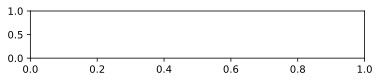

In [16]:
#v1 = [-2,1]
#v2 = [2,2]
#v3 = [1,-3]
#c = np.array([1,1])
#g = np.array([3,-2])
#inst_bvc = np.array([v1, v2, v3])

p_i = np.array([ 29.4 , -1.4])
p_f = np.array([-33.6 , -2.3])
n = np.array([[6.9 , 28.3], [-25.8 , 15.5], [-27.7, -19. ], [4.9 ,-30.9]])
radius = 1
plot_flag = True

solution = optimizer(p_i, p_f, n, radius, plot_flag, True)

print("That is: ", solution)

In [ ]:
#v1 = [-2,1]
#v2 = [2,2]
#v3 = [1,-3]
#c = np.array([1,1])
#g = np.array([3,-2])
#inst_bvc = np.array([v1, v2, v3])

r1 = np.array([-4,4])
r2 = np.array([-2,-1])
r3 = np.array([2,3])
t = np.array([3,-2])
radius = 0.2
plot_flag = True

solution = optimizer(r1, t, np.append([r2],[r3], axis=0), radius, plot_flag, False)

print("That is: ", solution)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Aug 25 02:03:31 PM: Your problem has 82 variables, 103 constraints, and 12 parameters.
(CVXPY) Aug 25 02:03:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 25 02:03:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 25 02:03:31 PM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 25 02:03:31 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Aug 25 02:03:31 PM: Applying reduction Dcp2Cone
(CVXPY) Aug 25 02:03:31 PM: Applying reduction CvxAttr2Constr
(CVXP

In [10]:
n_1 = np.array([6.9 , 28.3])
n_2 = np.array([-25.8 , 15.5])
n_3 = np.array([-27.7, -19. ])
n_4 = np.array([4.9 ,-30.9])

print(type(np.append([n_1,n_2,n_3],[n_4], axis=0)))

<class 'numpy.ndarray'>


np.linalg.norm(np.array([ 0.02024829, -0.47380743]) - np.array([-0.31552438, -0.30791811]))